### Before run this notebook, please go to the readme

In [1]:
import os
import json
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import gdal
import rasterio as rio
import rasterio.plot
from rasterio.crs import CRS
from rasterio import plot, mask, Affine
from scipy.spatial import cKDTree

In [2]:
pwd

'/home/jupyter/projects/PRJ-4604/landslides-M9motions'

In [3]:
# Defining the DEM path that was previously downloaded using USGS services. 
rasters_fn = "./0-rasters/"
figures_fn = "./1-figures/"
dem_fn = rasters_fn+"area_dtm.tif"

In [4]:
# Defining the project CRS: coordinates reference system
proj_crs = CRS.from_epsg(32610)
with rio.open(dem_fn, 'r+') as dataset:
    # Check if the dataset has a CRS
    if dataset.crs is None:
        dataset.crs = proj_crs

In [5]:
# Loading the DEM as a masked 2D-Array   
dem_src = rio.open(dem_fn)
dem_ma = dem_src.read(1, masked=True)

In [6]:
# Computing and loading the Hillshade as a masked 2D-Array
hs_fn = rasters_fn+'area_hs.tif'
!gdaldem hillshade $dem_fn $hs_fn

hs_src = rio.open(hs_fn)
hs_ma = hs_src.read(1, masked=True)

0...10...20...30...40...50...60...70...80...90...100 - done.


In [7]:
# Define extend of image/map
proj_extent = rio.plot.plotting_extent(dem_ma, dem_src.transform)

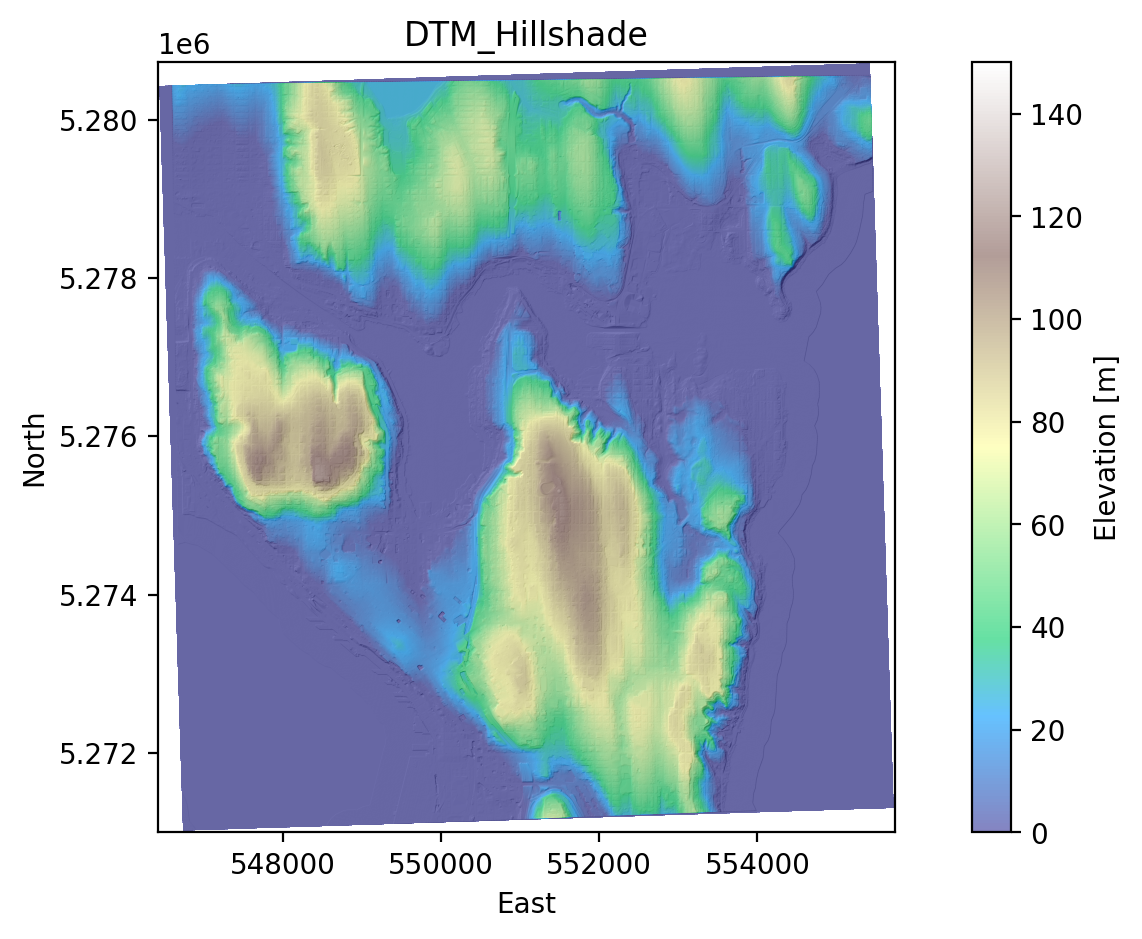

In [8]:
# DTM and Hillshade visualization 
xmin, xmax, ymin, ymax = proj_extent

f, ax = plt.subplots(figsize=(10,5), dpi=200)
ax.imshow(hs_ma, extent=proj_extent, cmap='gray')
im = ax.imshow(dem_ma, extent=proj_extent, vmin=0, vmax=150, cmap='terrain', alpha=0.6)
ax.set_title('DTM_Hillshade')
f.colorbar(im, ax=ax, label='Elevation [m]')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('East')
plt.ylabel('North')
plt.savefig(figures_fn+'0-dtm-hillshade.png', dpi=300)
plt.show()

In [9]:
# Computing and loading the Slope as a masked 2D-Array
slope_fn = rasters_fn+"area_slope.tif"
!gdaldem slope $dem_fn $slope_fn -of GTiff -b 1 -s 1.0

slope_src = rio.open(slope_fn)
slope_ma = slope_src.read(1, masked=True)

0...10...20...30...40...50...60...70...80...90...100 - done.


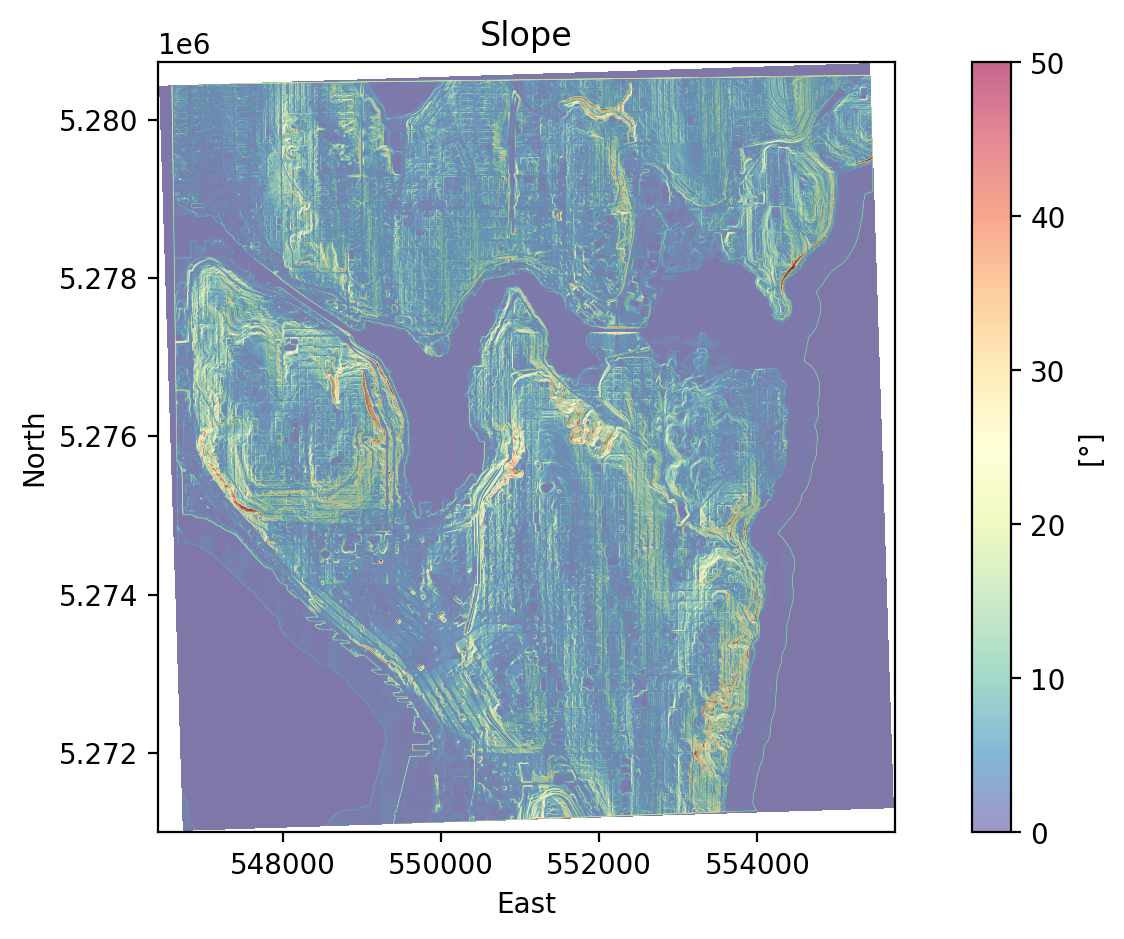

In [10]:
# Slope visualization 
xmin, xmax, ymin, ymax = proj_extent

f, ax = plt.subplots(figsize=(10,5), dpi=200)
ax.imshow(hs_ma, extent=proj_extent, cmap='gray')
im = ax.imshow(slope_ma, extent=proj_extent, vmin=0, vmax=50, cmap='Spectral_r', alpha=0.6)
ax.set_title('Slope')
f.colorbar(im, ax=ax, label='[°]')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('East')
plt.ylabel('North')
plt.savefig(figures_fn+'1-slope.png', dpi=300)
plt.show()

In [11]:
# Defining the Jibson model that calculates Newmark Displacement
def Jibson_Model(slope, gamma, c, phi, z, ia):
    """
        slope ---> degrees... derived from the dtm
        gamma ---> kN/m3... can be estimated with reference values and correlations with the geologic map
        c -------> kPa... can be estimated with reference values and correlations with the geologic map
        phi -----> degrees... can be estimated with reference values and correlations with the geologic map
        z -------> m... can be estimated with reference values and correlations with the geologic map
        ia ------> m/s... can be estimated using ground motions records for a certain area
    """
    
    fs_static = ((2*c)/(gamma*z*np.sin(2*np.deg2rad(slope)))) + ((1/np.tan(np.deg2rad(slope)))*np.tan(np.deg2rad(phi)))
    ac        = (fs_static-1)*np.sin(np.deg2rad(slope))
    dn        = 10**((1.460*np.log10(ia))-(6.642*ac)+(1.546)) #cm 
    return dn

In [12]:
# Defining a function that save a masked 2D-Array into a tiff file
def save_tif(array, src, output_path):

    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height
    dtype = src.dtypes[0]

    new_dataset = rio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=dtype,
        crs=crs,
        transform=transform,
    )

    # Write the sine values to the new TIFF file
    new_dataset.write(array, 1)

    # Close the dataset
    new_dataset.close()

In [13]:
# Defining a function that computes intensity measurements from the motions extracted in the M9 simulation. 
def get_intensity_from_motion(path_to_EventMotions):
    files = os.listdir(path_to_EventMotions)
    json_files = [file for file in files if file.endswith('.json')]
    
    keys = ["Station", "dT", "PGA", "PGV", "AriasI", "CAV"]
    eq_data = {key: [] for key in keys}
    
    g = 9.81 #m/s2
    
    for file, i in zip(json_files, range(len(json_files))):
        data = json.load(open(path_to_EventMotions+"/"+file))
        dT = data['dT']
        accel_x = data['accel_x']
        accel_y = data['accel_y']
        accel_z = data['accel_z']
        stationname = data['name'].split('_')[0]
    
        acc_g = np.array(accel_x)
        acc   = acc_g*g            #m/s2 
        vel   = np.zeros_like(acc) #m/s
        disp  = np.zeros_like(acc) #m
    
        for i in range(len(acc)-1):
            # Trapezoidal rule integration for velocity
            vel[i] = 0.5*(acc[i] + acc[i+1]) * dT
    
        for i in range(len(vel)-1):    
            # Trapezoidal rule integration for displacement
            disp[i] = 0.5 * (vel[i] + vel[i+1]) * dT
    
        PGA = max(abs(acc_g))
        PGV = max(abs(vel))
        Ia  = np.sum(dT * acc**2) * np.pi / (2*g)
        CAV = np.sum(np.abs(acc*dT))
        
        eq_data["Station"].append(stationname)
        eq_data["dT"].append(dT)
        eq_data["PGA"].append(PGA)
        eq_data["PGV"].append(PGV)
        eq_data["AriasI"].append(Ia)
        eq_data["CAV"].append(CAV)

    eq_data = pd.DataFrame(data=eq_data)
    
    return eq_data

In [14]:
# Defining a function that creates a geodataframe with point geometry from the stations in the motions of the M9 simulation 
def create_grid_gdf(sites_path, intensity_data, crs):
    column_names = ['Station', 'Latitude', 'Longitude']
    sites = pd.read_csv(sites_path, names=column_names, skiprows=[0])
    intensity_measures = pd.merge(intensity_data, sites, on="Station")
    im_gdf = gpd.GeoDataFrame(intensity_measures, 
                          geometry=gpd.points_from_xy(intensity_measures['Longitude'], intensity_measures['Latitude']), 
                          crs=CRS.from_epsg(4326))
    im_gdf = im_gdf.to_crs(crs)
    
    return im_gdf

In [15]:
# Defining a function that returns a masked 2D-Array with the intensity measure of interest that uses nearest neighbor interpolation
def nearest_interpolation_raster(src, gdf, intensity_measure, output_path):

    dem_profile  = src.profile
    no_data      = src.nodata
    
    ma = src.read(1, masked=True)
    no_data_mask = ma.mask
    
    i_profile = dem_profile.copy()
    i_profile.update(dtype=rio.float32, count=1, nodata=no_data)
    
    with rio.open(output_path, 'w', **i_profile) as dst:
        dst.write(np.full((dst.height, dst.width), no_data, dtype=rio.float32), 1)
    
    grid = [(point.x, point.y, intensity) for point, intensity in zip(gdf.geometry, gdf[intensity_measure])]
    
    xy = np.array([[point[0], point[1]] for point in grid])
    intensities = np.array([point[2] for point in grid])
    
    # Create a cKDTree for fast nearest-neighbor lookup
    tree = cKDTree(xy)
    
    # Create arrays for the new raster
    i_ma = np.full((i_profile['height'], i_profile['width']), no_data, dtype=np.float32)
    
    # Get the coordinates of the centers of the raster cells
    transform = i_profile['transform']
    rows, cols = i_ma.shape
    x_coords = np.arange(transform[2], transform[2] + transform[0] * cols, transform[0])
    y_coords = np.arange(transform[5], transform[5] + transform[4] * rows, transform[4])
    x_coords, y_coords = np.meshgrid(x_coords, y_coords)
    
    # Flatten the coordinate arrays for easier processing
    flat_x = x_coords.flatten()
    flat_y = y_coords.flatten()
    
    # Query the nearest neighbor for each raster cell center
    distances, indices = tree.query(np.column_stack((flat_x, flat_y)))
    
    # Assign the intensity values to the raster cells
    i_ma.flat = intensities[indices]
    
    # Apply the no-data mask from the original raster
    i_ma[no_data_mask] = no_data
    
    # Write the new raster data to the file
    with rio.open(output_path, 'w', **i_profile) as dst:
        dst.write(i_ma, 1)

    i_src = rio.open(output_path)
    i_ma = i_src.read(1, masked=True)

    return i_ma

## Extracting the motions

In [16]:
pwd

'/home/jupyter/projects/PRJ-4604/landslides-M9motions'

If you are not in the folder `M9App` run the following cell:

In [17]:
os.chdir("./M9App")

In [18]:
pwd

'/home/jupyter/projects/PRJ-4604/landslides-M9motions/M9App'

In [19]:
!rm -r EventMotions/

In [21]:
!pip install plotly

  Using cached plotly-5.22.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached tenacity-8.3.0-py3-none-any.whl.metadata (1.2 kB)
Using cached plotly-5.22.0-py3-none-any.whl (16.4 MB)
Using cached tenacity-8.3.0-py3-none-any.whl (25 kB)


In [23]:
!pip install agavepy

  Using cached agavepy-0.9.5-py2.py3-none-any.whl.metadata (9.4 kB)
  Using cached backports.ssl_match_hostname-3.7.0.1.tar.gz (5.7 kB)
  Preparing metadata (setup.py) ... done
  Using cached py-1.11.0-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached pytest-8.2.2-py3-none-any.whl.metadata (7.6 kB)
  Using cached websocket_client-0.53.0-py2.py3-none-any.whl.metadata (7.6 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached configparser-7.0.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached iniconfig-2.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached pluggy-1.5.0-py3-none-any.whl.metadata (4.8 kB)
Using cached agavepy-0.9.5-py2.py3-none-any.whl (183 kB)
Using cached websocket_client-0.53.0-py2.py3-none-any.whl (198 kB)
Using cached configparser-7.0.0-py3-none-any.whl (16 kB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached py-1.11.0-py2.py3-none-any.whl (98

In [24]:
# Importing classes to run the M9App
import M9Stations
import M9App2

In [25]:
# Defining the imput parameters needed in the M9App
information = { 'RegionFlag': True, 
                    'LocationFlag': False, 
                    'lat': 47.657355, 
                    'lon': -122.342004,
                    'grid_type': 'A', 
                    'number_of_realizations': 2,
                    'APIFLAG': False,
                    'directory': 'EventMotions',
                    'RegionShape': "Circle",
                    'radius': 10 #km
                    }
M9Stations.getStations(information,plot=False,show=False)

In [26]:
# Downloading the motions from the M9 simulation
M9Stations.getStations(information,plot=True,show=False)
M9App2.Submit_tapis_job()

Uploading files to designsafe storage
Submitting job
Job status:  PROCESSING_INPUTS
Job status:  RUNNING
Job status:  ARCHIVING
Job status:  FINISHED


In [27]:
# Computing the intensities from this example simulation 
eventMotions_fn = "./EventMotions"
motions_i = get_intensity_from_motion(eventMotions_fn)

In [28]:
# Creating the motions grid geodataframe
i_gdf     = create_grid_gdf(sites_path="./M9_sites.csv", 
                            intensity_data=motions_i, 
                            crs=proj_crs)

In [29]:
pwd

'/home/jupyter/projects/PRJ-4604/landslides-M9motions/M9App'

In [30]:
cd ..

/home/jupyter/projects/PRJ-4604/landslides-M9motions


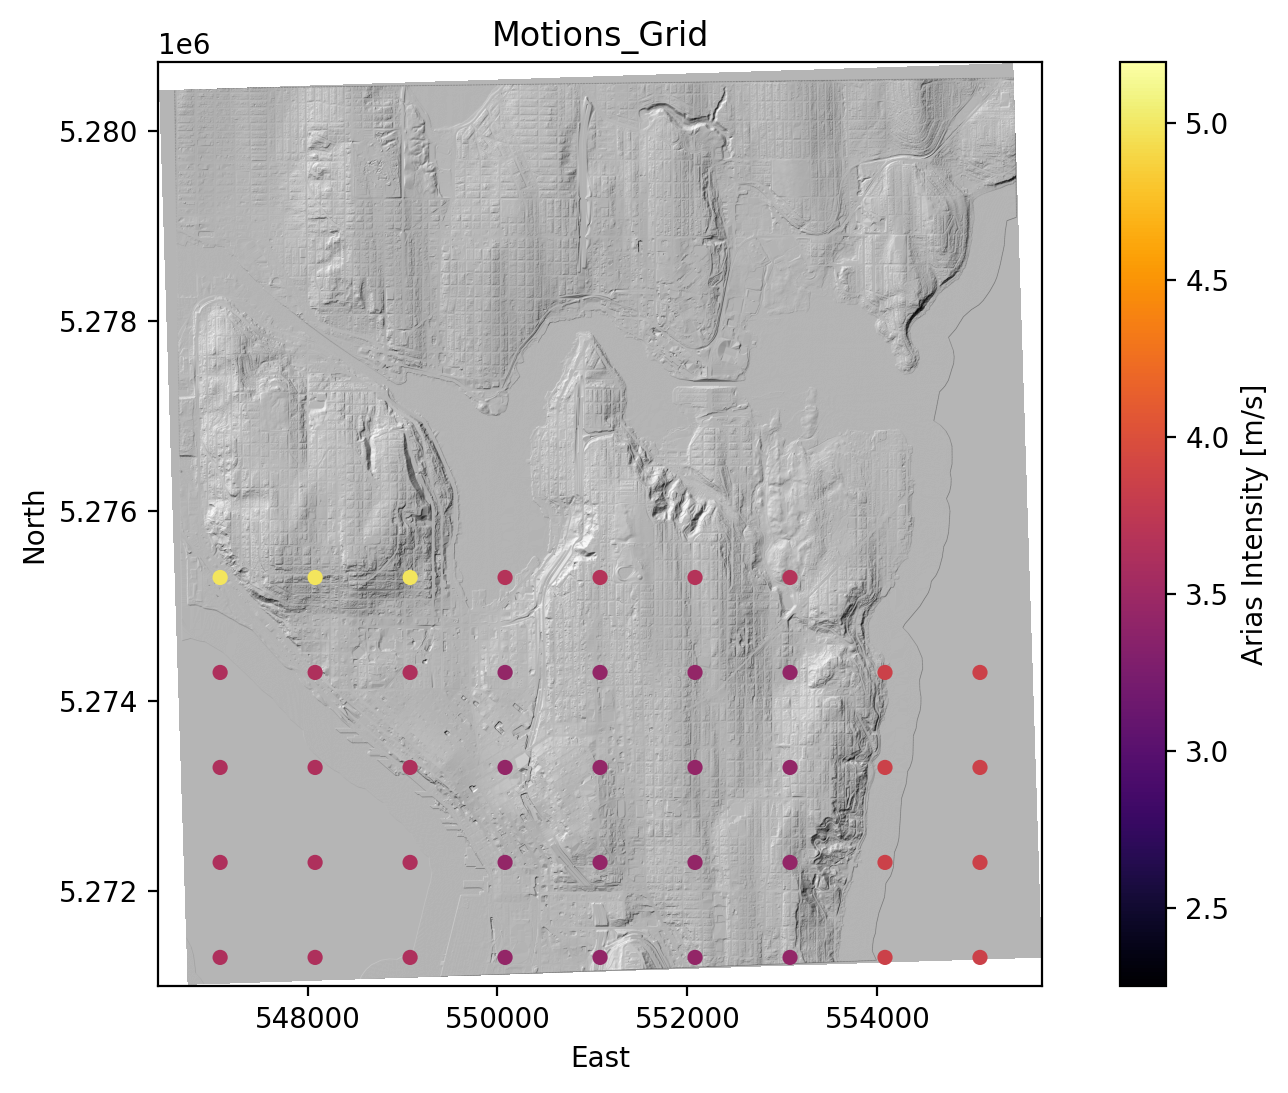

In [31]:
# Grid of motions visualization 
xmin, xmax, ymin, ymax = proj_extent
leg = 'AriasI'
f, ax = plt.subplots(figsize=(10,6), dpi=200)
ax.imshow(hs_ma, extent=proj_extent, cmap='gray')
i_gdf.plot(column=leg, cmap='inferno', 
            vmin=np.percentile(i_gdf[leg], 2), vmax=np.percentile(i_gdf[leg], 98), 
            ax=ax, s=20, legend=True, legend_kwds={'label': 'Arias Intensity [m/s]'})
ax.set_title('Motions_Grid')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('East')
plt.ylabel('North')
plt.savefig(figures_fn+'2-motions-grid.png', dpi=300)
plt.show()

In [32]:
# creating a raster with intensity measures that uses nearest neighbor interpolation
i_ma      = nearest_interpolation_raster(src=dem_src, 
                                         gdf=i_gdf, 
                                         intensity_measure='AriasI', 
                                         output_path=rasters_fn+'intensity_measure.tif')

In [33]:
# computing the Newmark displacement using the Jibson model
dn = Jibson_Model(slope=slope_ma, 
                  gamma=15, 
                  c=10, 
                  phi=35, 
                  z=5, 
                  ia=i_ma)

/tmp/ipykernel_3784/4071706211.py:13: RuntimeWarning:

invalid value encountered in log10



In [ ]:
# saving the Newmark displacement 2D-Array into a tiff file
dn_fn = rasters_fn+'newmark_displacement.tif'
save_tif(array=dn, 
         src=dem_src, 
         output_path=dn_fn)

In [ ]:
# loading the saved Newmark displacement tiff file as a masked array for visualization
dn_src = rio.open(dn_fn)
dn_ma = dn_src.read(1, masked=True)

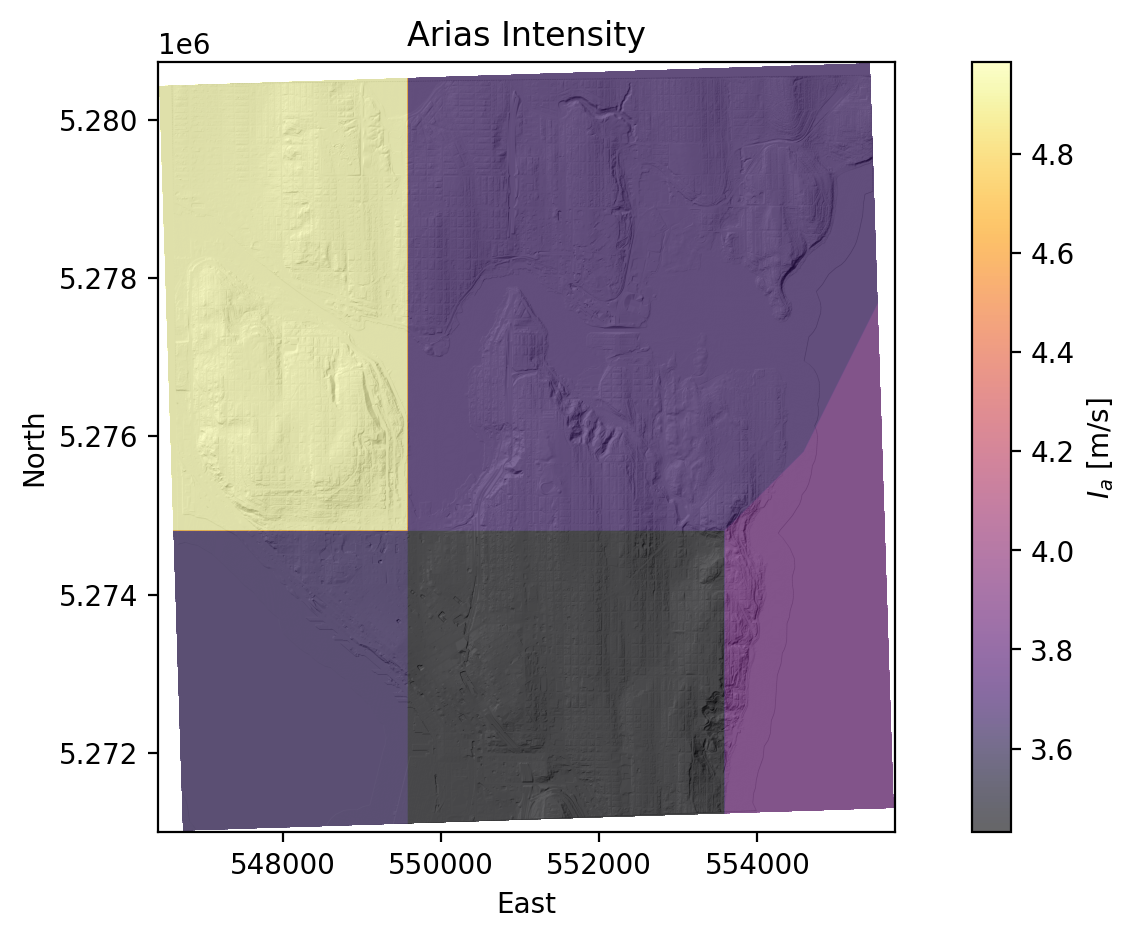

In [34]:
# Intensity measure raster (calculated with the nearest neighbor) visualization 
xmin, xmax, ymin, ymax = proj_extent

f, ax = plt.subplots(figsize=(10,5), dpi=200)
ax.imshow(hs_ma, extent=proj_extent, cmap='gray')
im = ax.imshow(i_ma, extent=proj_extent, cmap='inferno', alpha=0.6)
ax.set_title('Arias Intensity')
f.colorbar(im, ax=ax, label='$I_a$ [m/s]')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('East')
plt.ylabel('North')
plt.savefig(figures_fn+'3-nearest-neighbor.png', dpi=300)
plt.show()

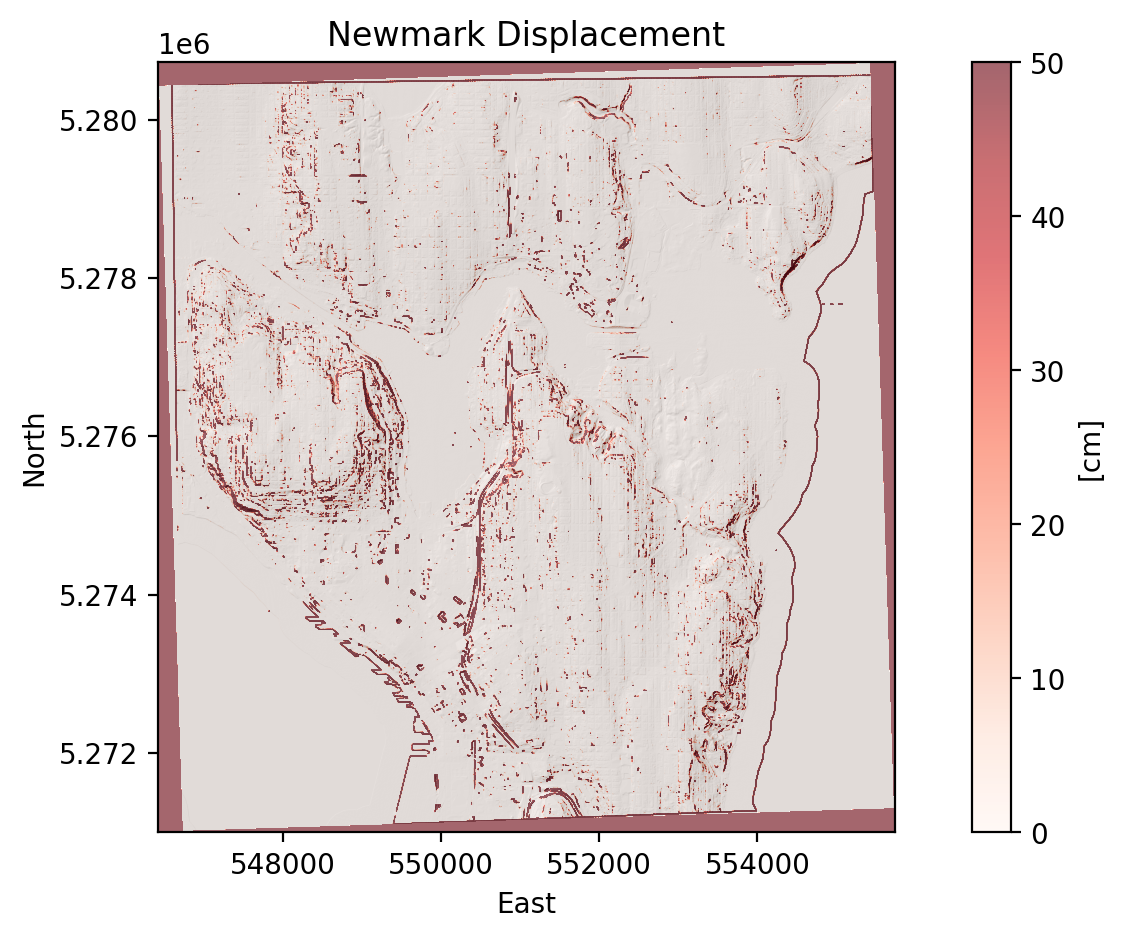

In [35]:
# Newmark displacement raster visualization 
xmin, xmax, ymin, ymax = proj_extent

f, ax = plt.subplots(figsize=(10,5), dpi=200)
ax.imshow(hs_ma, extent=proj_extent, cmap='gray')
im = ax.imshow(dn_ma, extent=proj_extent, vmin=0, vmax=50, cmap='Reds', alpha=0.6)
ax.set_title('Newmark Displacement')
f.colorbar(im, ax=ax, label='[cm]')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('East')
plt.ylabel('North')
plt.savefig(figures_fn+'4-newmark-displacement.png', dpi=300)
plt.show()